In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortex"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 512)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 512)

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [11]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.1min


[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total= 3.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139442, total= 3.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.139165, total= 3.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137695, total= 3.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.139442, total= 3.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137255, total= 3.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 3.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  8.1min


[CV] .............. C=0.01, gamma=1e-08, score=0.136986, total= 4.9min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137255, total= 5.0min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 5.0min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139165, total= 5.0min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138751, total= 5.0min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138477, total= 5.0min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 5.0min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.3min


[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 3.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138477, total= 3.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138751, total= 3.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139165, total= 3.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139442, total= 3.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138889, total= 3.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.137695, total= 3.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.6min


[CV] .............. C=0.01, gamma=0.001, score=0.458824, total= 2.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.450787, total= 2.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.464775, total= 2.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.456693, total= 2.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.456973, total= 2.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.463826, total= 2.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.476143, total= 2.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 16.4min


[CV] ............. C=0.01, gamma=0.0001, score=0.336275, total= 5.0min
[CV] ............. C=0.01, gamma=0.0001, score=0.337598, total= 5.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.339268, total= 5.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.343504, total= 5.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.338949, total= 5.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.343254, total= 5.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138751, total= 5.2min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 20.4min


[CV] ............... C=0.01, gamma=0.01, score=0.366963, total= 3.7min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.382557, total= 3.7min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.378968, total= 3.7min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.378728, total= 3.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.363546, total= 3.7min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.213867, total= 4.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.203523, total= 4.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 26.6min


[CV] ................ C=0.01, gamma=1.0, score=0.198819, total= 4.3min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.200791, total= 4.3min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.189216, total= 6.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.207136, total= 4.4min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.197652, total= 7.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.204102, total= 6.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.201195, total= 4.3min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 31.7min


[CV] ............... C=0.1, gamma=1e-08, score=0.138477, total= 3.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138889, total= 3.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137695, total= 3.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.136986, total= 3.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137255, total= 3.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total= 3.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138477, total= 3.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 35.0min


[CV] ............... C=0.1, gamma=1e-08, score=0.139442, total= 4.9min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total= 5.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.155600, total= 7.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.01, gamma=10.0, score=0.156746, total= 7.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.01, gamma=10.0, score=0.155070, total= 7.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.01, gamma=10.0, score=0.155378, total= 7.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.137695, total= 3.2min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 39.7min


[CV] ............... C=0.1, gamma=0.001, score=0.834638, total= 1.3min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.807843, total= 1.3min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.781496, total= 1.5min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.794263, total= 1.5min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.802775, total= 1.5min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.801181, total= 1.3min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.790675, total= 1.5min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 42.4min


[CV] ............... C=0.1, gamma=1e-05, score=0.390196, total= 4.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.394685, total= 4.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.389764, total= 4.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.394659, total= 4.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.392468, total= 4.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.393849, total= 4.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.389662, total= 4.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 49.1min


[CV] ................ C=0.1, gamma=0.01, score=0.454183, total= 5.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.324853, total= 6.5min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.315430, total= 6.6min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=1.0, score=0.270030, total= 4.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.265748, total= 4.3min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.271556, total= 4.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.280754, total= 4.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 54.5min


[CV] ................ C=0.1, gamma=10.0, score=0.222441, total= 4.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.226508, total= 4.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137695, total= 3.0min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137255, total= 3.1min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137795, total= 3.0min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.138477, total= 3.0min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.136986, total= 3.2min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 60.9min


[CV] ............... C=1.0, gamma=1e-06, score=0.393346, total= 2.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.137795, total= 5.1min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138477, total= 5.1min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.393137, total= 2.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.228628, total= 7.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.397638, total= 2.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.390748, total= 2.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 63.6min


[CV] .............. C=1.0, gamma=0.0001, score=0.895669, total= 1.1min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.938356, total= 1.0min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.917903, total= 1.1min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.910537, total= 1.1min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.932353, total= 1.0min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.924213, total=  59.9s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.943898, total=  59.9s
[CV] C=1.0, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 68.9min


[CV] ................ C=1.0, gamma=0.01, score=0.636454, total= 3.2min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................. C=1.0, gamma=0.1, score=0.382812, total= 4.1min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.364173, total= 4.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.387255, total= 4.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.370079, total= 4.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.389432, total= 4.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.369931, total= 4.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 76.4min


[CV] ................ C=1.0, gamma=10.0, score=0.283333, total= 4.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.282480, total= 4.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.279528, total= 4.4min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.292779, total= 4.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.328431, total= 6.8min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.324803, total= 6.8min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.137695, total= 3.1min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 82.3min


[CV] .............. C=10.0, gamma=1e-08, score=0.137795, total= 5.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.138751, total= 5.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.138889, total= 5.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.785433, total= 1.4min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.786350, total= 1.4min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.895303, total=  39.2s
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.876471, total=  39.0s
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 84.5min


[CV] .............. C=10.0, gamma=1e-07, score=0.392644, total= 4.7min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.405378, total= 4.7min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.943340, total=  42.5s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.931641, total= 1.1min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.945205, total= 1.1min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.932087, total= 1.1min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.953740, total= 1.1min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 91.8min


[CV] ............... C=10.0, gamma=0.01, score=0.649802, total= 5.3min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=1.0, score=0.330078, total= 4.2min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=1.0, score=0.348337, total= 4.3min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ............... C=10.0, gamma=0.01, score=0.655378, total= 5.3min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.01, score=0.679920, total= 5.3min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.392578, total= 6.7min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.325787, total= 4.3min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 99.7min


[CV] ............. C=100.0, gamma=1e-08, score=0.396282, total= 4.7min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.388672, total= 4.7min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.785433, total= 1.4min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.787339, total= 1.4min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.781250, total= 2.3min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.789891, total= 1.4min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.783730, total= 1.4min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 102.4min


[CV] ............. C=100.0, gamma=1e-05, score=0.928287, total=  25.8s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.934570, total=  26.4s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.947162, total=  26.5s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.905847, total= 1.1min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.894841, total= 1.0min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.396825, total= 4.7min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.392644, total= 4.8min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 107.9min


[CV] .............. C=100.0, gamma=0.01, score=0.649414, total= 5.2min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.665362, total= 5.3min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............... C=100.0, gamma=0.1, score=0.384768, total= 4.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=100.0, gamma=0.1, score=0.379921, total= 4.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=100.0, gamma=0.1, score=0.386521, total= 4.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.641732, total= 5.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.647059, total= 5.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 116.4min


[CV] .............. C=100.0, gamma=10.0, score=0.290196, total= 4.5min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.776892, total= 1.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.293360, total= 4.5min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.313121, total= 4.5min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.296813, total= 4.6min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.887795, total=  39.4s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.914936, total=  39.5s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 119.0min


[CV] ............ C=1000.0, gamma=1e-06, score=0.931412, total=  41.4s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.950000, total=  26.5s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.928150, total=  26.1s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.923828, total=  39.0s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.939335, total=  39.6s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.945866, total=  26.9s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.928287, total=  42.0s
[CV] C=1000.0, gamma=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 133.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
top_model.cv_results_

{'mean_fit_time': array([ 234.63680568,  225.44150651,  183.92277672,  222.10221877,
         255.32185757,  147.81619701,  211.58919032,  365.26869903,
         307.16472452,  308.36689184,  241.77717285,  182.7018146 ,
         175.96387937,  241.68088248,  100.75145676,   71.38202779,
         215.33834729,  321.21433198,  299.45427885,  306.52951381,
         192.47289889,  241.30798881,  182.0878263 ,  103.7748945 ,
          42.49275091,   54.59246941,  229.6055341 ,  288.84210789,
         298.34683964,  309.80579529,  218.05956488,  201.0917974 ,
          89.43405449,   34.83703418,   28.95324407,   66.91989717,
         257.7957988 ,  297.44130731,  275.16423144,  321.13517041,
         223.84215395,   85.270807  ,   37.51647437,   23.67183263,
          26.95522089,   66.66117501,  256.1918324 ,  295.42663255,
         306.61131389,  322.96532347,   94.38780653,   37.01623986,
          23.85884352,   25.42453582,   21.84932418,   71.09127967,
         248.76911099,  297.406

In [13]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.34067, std: 0.00322, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.46192, std: 0.00734, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.36869, std: 0.00952, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.21014, std: 0.00714, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.20077, std: 0.00478, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.15371, std: 0.00236, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.001} - score: 0.9446


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


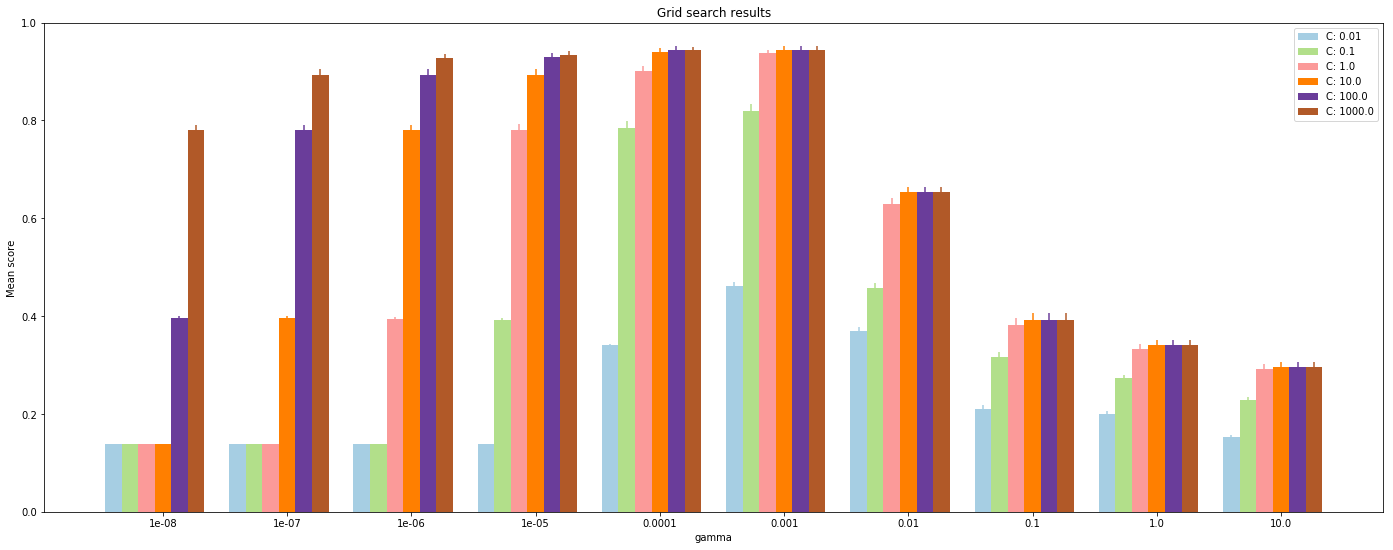

In [15]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()